In [25]:
%run classes.ipynb
# Training cell
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold




emptyRatioA = 47
emptyRatioB = 30
emptyRatioC = 24
objectwidth = 83
objectheight = 122

odtype = 'moran'
neighbourhoodDistance = 5
porositythreshold = 0.5
neighbourhoodZ = 1
windowSize = 75
windowAdvance = 25
noOfBins = 20
n_neighbors = 3
test_size = 0.4
hsegments = [0,26,50,74,98,122]
mask = np.zeros((objectwidth, objectheight))
bend = 225

X_train = readRawTreeImages()
labels = getLabels(porositythreshold)
Y_train = np.copy(labels)

# Todo: Uncomment this line

mask = makeMask(X_train, emptyRatioA)

bgr = backgroundRemover(mask)
ab = blockAccumulator(windowSize, windowAdvance)
oc1 = outlierCalculator(odtype, neighbourhoodDistance, neighbourhoodZ)
# a1 = accumulator(windowSize, windowOffset)

# Hur modellerar vi det här? Objekt med olika höjd blir kaos, eller? Skulle kunna skicka tomma bilder när de är slut. 

allTrainingHists = []

def makesegments(image, hsegments):
    segments = []
    for obimg in image:
        for i in range(len(hsegments)-1):
            segments.append(obimg[hsegments[i]:hsegments[i+1],:])
    return segments

trainObjects1 = np.moveaxis(X_train, 1, 0)

allOcvals = []
allPresValues = []
i = 0
for image in trainObjects1:
    # Ta bilden, omvandla till en array av bilder (en bild per obj)
    # Vilken struktur behöver preprocess? Lista med numpy array
    # image är 26x122x83
    # segments ska vara (26*5)x122x83
    noback = bgr.removeBackground(image)
    segments = makesegments(noback, hsegments)
    segmentblocks = ab.next(segments)
    if(segmentblocks is False):
        continue
    # plt.hist(trainoutliers[0][1].flatten(), bins=bincount, range=(minval, maxval))
    ocvals = oc1.calculate(segmentblocks)
    allOcvals.append(ocvals)
    i+=1
    # if(i == 0 or i == 1 or i == 2):
    #     plt.imshow(pres[0])
    #     plt.figure()
    #     plt.hist(pres[0].flatten())
    #     plt.yscale('log')
    #     plt.figure()
    # ocVals: List[layers][objects][matrix]

acount = len(trainObjects1)
ab.reset()

X_train2 = readRawHouseImages()
trainObjects2 = np.moveaxis(X_train2, 1, 0)
maskB = makeMaskB(X_train2, emptyRatioB)
bgrb = backgroundRemover(maskB)
for image in trainObjects2:
    noback = bgrb.removeBackground(image)
    segments = noback
    segmentblocks = ab.next(segments)
    if(segmentblocks is False):
        continue
    ocvals = oc1.calculate(segmentblocks)
    allOcvals.append(ocvals)

ocmin = np.nanmin(np.concatenate([np.concatenate([o.flatten() for o in oo]) for oo in allOcvals]))
ocmax = np.nanmax(np.concatenate([np.concatenate([o.flatten() for o in oo]) for oo in allOcvals]))
e1 = encoder(noOfBins, ocmin, ocmax)

for ocvals in allOcvals:
    if len(ocvals) > 0:
        # Print a chart here
        # tar encode en lista av 3d?
        hists = e1.encode(ocvals)
        for acc in hists:
            allTrainingHists.append(acc)


In [26]:
labelRanges = [(i, i+windowSize) for i in range(0, bend-windowSize+1, windowAdvance)]
ytrainb = [getLabelsB(objIndex, 0.5, start, end) for (start, end) in labelRanges for objIndex in range(1,29)]
repetitionsA = (len(allTrainingHists)-len(ytrainb)) // len(Y_train)
knn = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform", n_jobs=-1)
scaler = StandardScaler()
clf = Pipeline([('scaler', scaler), ('classifier', knn)])
ytrain2 = np.tile(Y_train.astype('int'), [np.int32(repetitionsA)])
ytrainboth = np.concatenate([ytrain2, ytrainb])
clf.fit(allTrainingHists, ytrainboth)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=3))])

In [27]:
np.shape(allTrainingHists)

(896, 20)

In [28]:
# xtrain_real = allTrainingHists
# ytrain_real = ytrainboth
# xtest_real = testx
# ytest_real = y_test

In [29]:
%run classes.ipynb
# Testing cell
from sklearn.metrics import f1_score, roc_auc_score
import time
X_test = readCSet()
# shape of X_test is objects x layers x width x height

def test(windowSize, windowAdvance, ):
    twindowSize = windowSize
    twindowAdvance = windowAdvance

    ab = blockAccumulator(twindowSize, twindowAdvance)

    # X_test = readRawHouseImages()
    testObjects = np.moveaxis(X_test, 1, 0)
    # shape of testObjects is layers x objects x width x height
    maskB = makeMaskB(X_test, emptyRatioB)
    bgrb = backgroundRemover(maskB)

    testx = []
    predictions = []
    times = []
    letsPrint = False
    for i in range(0, len(testObjects)):
        image = testObjects[i]
        # Start of timing
        start_time = time.time()
        noback = bgrb.removeBackground(image)
        # segments = makesegments(noback, hsegments)
        segments = noback
        segmentblocks = ab.next(segments)
        if(segmentblocks is False):
            continue
        # why is the blockAccumulator summing across one axis? Is it flattening all layers? That seems wrong...
        ocvals = oc1.calculate(segmentblocks)
        hists = e1.encode(ocvals)
        pred = clf.predict_proba(hists)[:,1]
        times.append(time.time() - start_time)
        # End of timing
        testx.append(hists)
        predictions.append(pred)
        # %run classes.ipynb

    # investigate accuracy etc here. Potentially batch it based on layer
    labelRanges = [(i, i+twindowSize) for i in range(0, bend-twindowSize+1, twindowAdvance)]
    y_test = [getLabelsC(objIndex, 0.5, start, end) for (start, end) in labelRanges for objIndex in range(1,26)]
    # y_test = [getLabelsB(objIndex, 0.5, start, end) for (start, end) in labelRanges for objIndex in range(1,29)]
    ysvalue = []
    relevantTimes = []
    relevantPredictions = []
    relevantYTrues = []
    for index, o in enumerate(predictions):
        ysThatMayBeNan = np.array(y_test[index*25:(index+1)*25])
        predictionsOfInterest = o[~np.isnan(ysThatMayBeNan)]
        nonNanYs = ysThatMayBeNan[~np.isnan(ysThatMayBeNan)]
        if len(nonNanYs) > 0 and np.unique(nonNanYs).size > 1:
            ysvalue.append(roc_auc_score(nonNanYs, predictionsOfInterest))
            relevantTimes.append(times[index])
            relevantPredictions.append(predictionsOfInterest)
            relevantYTrues.append(nonNanYs)
        
    # plt.plot([s for (s, e) in labelRanges], ysvalue, 'o-', markersize=2)
    # print(np.mean(ysvalue))
    # plt.ylabel("ROC-AUC")
    # plt.xlabel("Window start layer")
    # plt.axline((0, 0.975), (1, 0.975), color='g', linestyle='--')
    # plt.axline((0, 0.5), (1, 0.5), color='r', linestyle='--')
    # plt.figure()
    # plt.plot([s for (s, e) in labelRanges], times, 'o-', markersize=2)
    # plt.axline((0, 11.82), (1, 11.82), color='g', linestyle='--')
    # # plt.axline((0, 10.75), (1, 10.75), color='g', linestyle='--')
    # plt.ylabel("Execution time (s)")
    # plt.xlabel("Window start layer")
    return ysvalue, relevantTimes, relevantPredictions, relevantYTrues

In [30]:
# WA is (50% of WS), while ensuring 5 samples
settings = [(5, 3),
            # (15, 8),
            (25, 13),
            # (50, 25),
            (75, 30),
            (105, 52),
            #(125, 15),
            #(150, 15),
            #(175, 20),
            #(200, 10),
            (212, 13)]


In [31]:
import pickle


results = []
for (windowSize, windowAdvance) in settings:
    results.append(test(windowSize, windowAdvance))
pickle.dump(results, open("results.p", "wb"))
# Update the green line, should be the batch processing result for the new dataset
# Remove the outliers from the dataset (the ones above like 10% porosity)
# Write pseudokode for friday
# Run the economic evaluation first, then iterate on results...
# pickle and store results on disk

In [32]:
import pickle
import numpy as np
# WA is (50% of WS), while ensuring 5 samples
settings = [(5, 3),
            # (15, 8),
            (25, 13),
            # (50, 25),
            (75, 30),
            (105, 52),
            #(125, 15),
            #(150, 15),
            #(175, 20),
            #(200, 10),
            (212, 13)]

ws = [w for (w, a) in settings]
results = pickle.load(open("results.p", "rb"))
fpr = []
fnr = []

for (_, _, pred, true) in results:
    pred = np.where(np.concatenate(pred) < 0.5, 0, 1).astype(bool)
    true = np.concatenate(true).astype(bool)
    fpr.append(
        (np.sum(pred & ~true)) / np.sum(~true)
    )
    fnr.append(
        (np.sum(~pred & true)) / np.sum(true)
    )


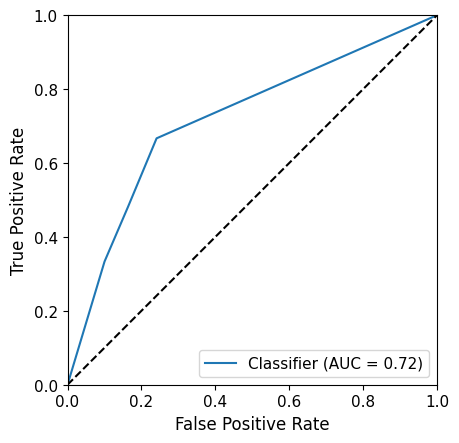

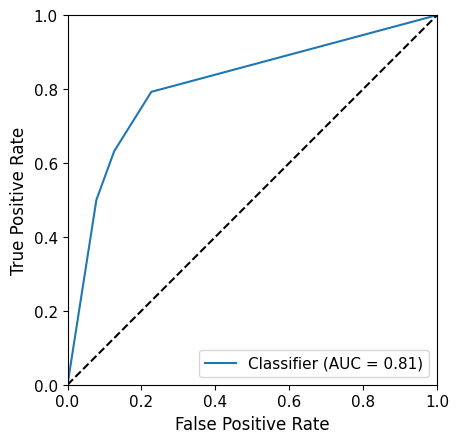

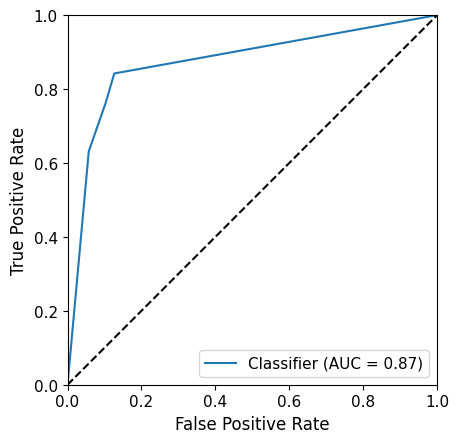

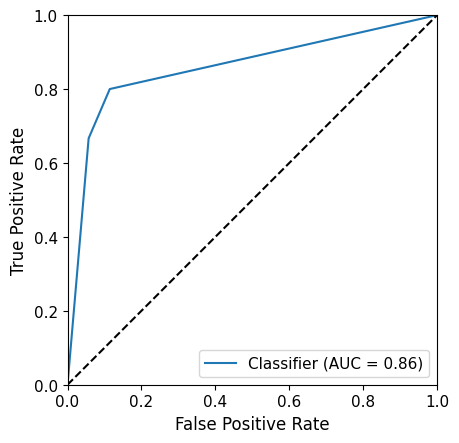

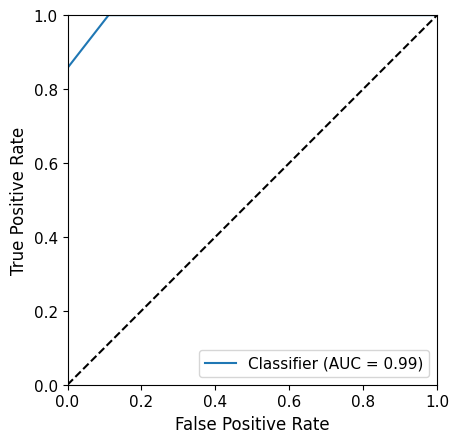

In [45]:
from sklearn import neighbors, metrics
import matplotlib.pyplot as plt
base_size = 10

plt.rcParams.update({
    'font.size': base_size+1,          # Base font size
    'axes.titlesize': base_size+3,    # Title size
    'axes.labelsize': base_size+2,     # Axis label size
    'xtick.labelsize': base_size+1,    # X-tick label size
    'ytick.labelsize': base_size+1,    # Y-tick label size
    'legend.fontsize': base_size+1,    # Legend font size
    'legend.title_fontsize': base_size+1  # Legend title font size
})
i = 0
for (_, _, pred, true) in results:
    metrics.RocCurveDisplay.from_predictions(np.concatenate(true), np.concatenate(pred))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.plot((0, 1), (0, 1), color='black', linestyle='--')
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.legend().set_visible(False)
    plt.savefig(str(settings[i][0])+"-roc.pdf", dpi=300, bbox_inches='tight')
    i += 1

# Set aspect ratio to be equal

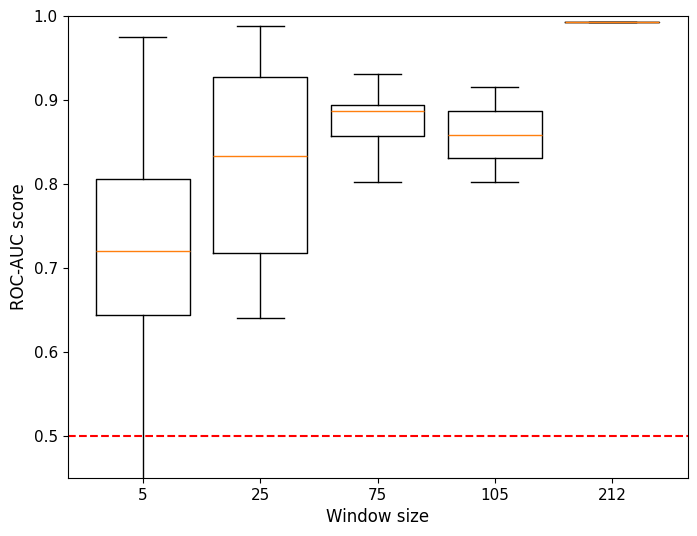

In [46]:
# all = [np.array(s) for (s, t, _, _) in results][0::2]
all = [np.array(s) for (s, t, _, _) in results]
# scores = [np.average(s) for (s, t) in results]
# median = [np.median(s) for (s, t) in results]
# minscore = [np.average(s) - np.std(s) for (s, t) in results]
# maxscore = [np.average(s) + np.std(s) for (s, t) in results]
# times = [t for (s, t) in results]
# plt.plot(ws, scores, 'o-', markersize=2)
# plt.plot(ws, minscore, 'o-', markersize=2)
# plt.plot(ws, maxscore, 'o-', markersize=2)
plt.rc('font', size=16)
plt.figure(figsize=(8,6))
plt.boxplot(all, positions=range(0, len(all)*10, 10), widths=8, showfliers=False, whis=[0, 100])
plt.xlabel("Window size")
plt.ylabel("ROC-AUC score")
plt.xticks(range(0, len(all)*10, 10), ws)
plt.axline((0, 0.5), (1, 0.5), color='r', linestyle='--')
plt.gca().set_ylim(0.45, 1)
plt.savefig("rocauc.pdf", dpi=300, bbox_inches='tight')



# plt.plot(ws, median, 'o-', markersize=2)
# plt.xscale('log')

[1.00031677 0.9891515  1.00331478 1.01301427 0.98907602]
[0.96848816 0.94472823 0.95970884 0.97830785 0.97811535]
[0.9366456  0.90027197 0.91605578 0.94353728 0.96723262]
[0.90477091 0.85585532 0.87239761 0.90880873 0.95630854]


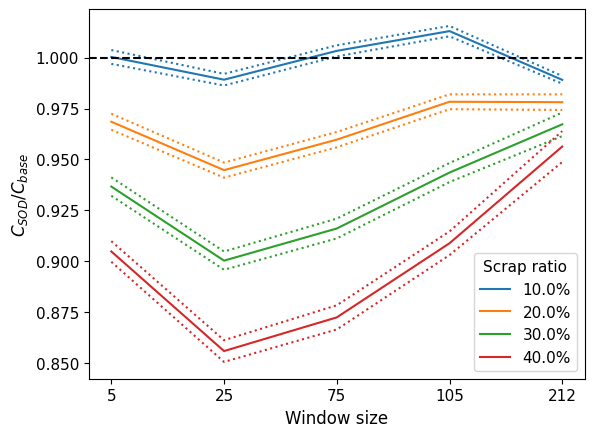

In [47]:
%run classes.ipynb

from scipy.stats import norm

def bonferroni_confidence_interval(data, alpha=0.05):
    n, m = data.shape  # Get the dimensions of the array
    z = norm.ppf(1 - alpha / (2 * m))  # Calculate the Bonferroni adjusted Z-score

    # Initialize an array to store the confidence intervals
    confidence_intervals = np.zeros((2, m))

    # Iterate over each column (test)
    for j in range(m):
        mean = np.mean(data[:, j])  # Calculate the mean of the column
        std_dev = np.std(data[:, j], ddof=1)  # Calculate the standard deviation of the column

        # Calculate the margin of error
        margin_of_error = z * (std_dev / np.sqrt(n))

        # Calculate the confidence interval
        lower_bound = mean - margin_of_error
        upper_bound = mean + margin_of_error

        confidence_intervals[:, j] = [lower_bound, upper_bound]  # Store the confidence interval

    return confidence_intervals

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

samples = 10000
scrapRatio = [0.1, 0.2, 0.3, 0.4]
wsa = np.array(ws)
layers = np.where(wsa > 50, wsa+1, wsa)
CR = (layers + 13) / 225
# Each fpr, tpr, cr pair can make it's own plot. Let's draw all of them?
res = np.empty(shape=(len(scrapRatio), len(CR), samples))
flat = np.empty(shape=(samples, len(scrapRatio) * len(CR)))
confidence = np.empty(shape=(len(scrapRatio), len(CR), 2))
mean = np.empty(shape=(len(scrapRatio), len(CR)))
for i in range(0, len(CR)):
    for k in range(0, len(scrapRatio)):
        for l in range(0, samples):
            res[k, i, l] = getCost(scrapRatio[k], fpr[i], fnr[i], min(CR[i], 1))

for i in range(0, len(scrapRatio)):
    plt.plot(range(0, 5), np.mean(res[i], axis=1) + 2*np.std(res[i], axis=1), linestyle=':', c=f"C{i}")
    plt.plot(range(0, 5), np.mean(res[i], axis=1) - 2*np.std(res[i], axis=1), linestyle=':', c=f"C{i}")
    plt.plot(range(0, 5), np.mean(res[i], axis=1), label= f"{scrapRatio[i]*100}%", c=f"C{i}")
    print(np.mean(res[i], axis=1))
plt.xticks(range(0, 5), ws)
plt.axline((0, 1), (1, 1), color='black', linestyle='--')
plt.legend(title="Scrap ratio", )
plt.xlabel("Window size")
plt.ylabel("$C_{SOD} / C_{base}$")
plt.savefig("cost.pdf", dpi=300, bbox_inches='tight')

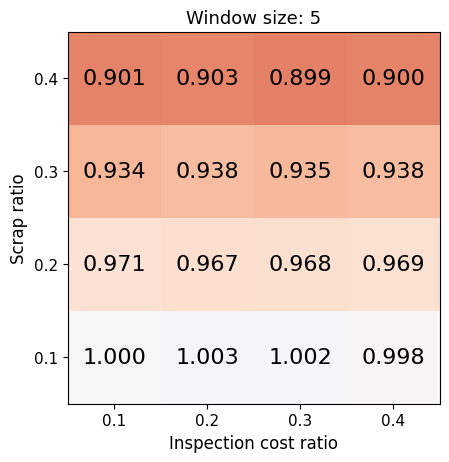

<Figure size 640x480 with 0 Axes>

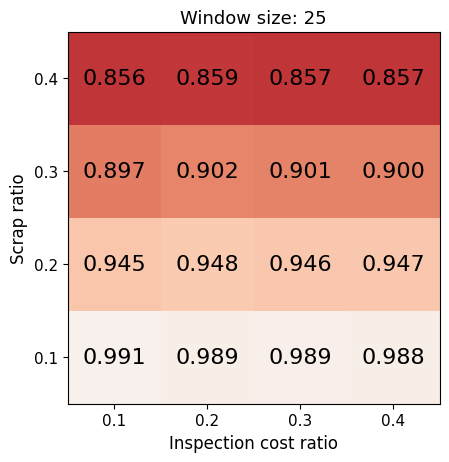

<Figure size 640x480 with 0 Axes>

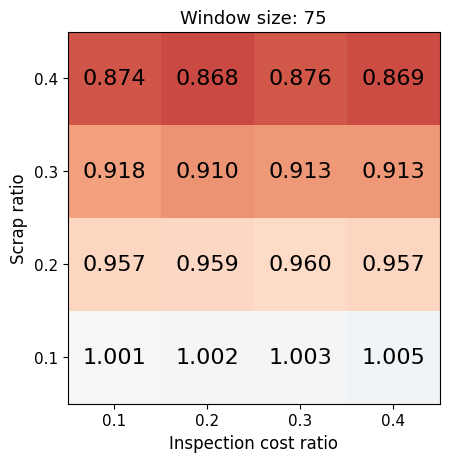

<Figure size 640x480 with 0 Axes>

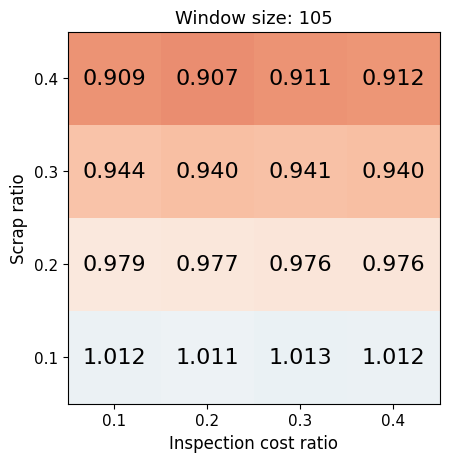

<Figure size 640x480 with 0 Axes>

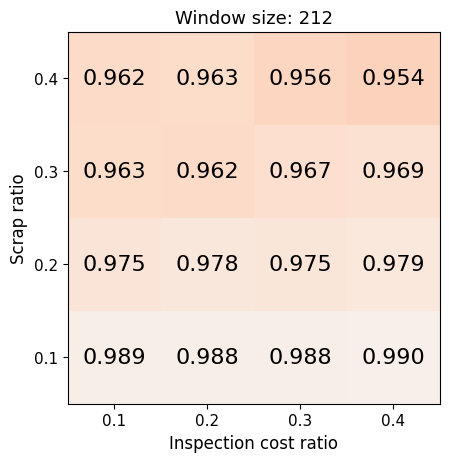

<Figure size 640x480 with 0 Axes>

In [48]:
import matplotlib as mpl
scrapRatio = [0.1, 0.2, 0.3, 0.4]
Cins = [0.1, 0.2, 0.3, 0.4]
CR = (np.array(ws) + 13) / 225
fpr
fnr
# Each fpr, tpr, cr pair can make it's own plot. Let's draw all of them?
for i in range(0, len(CR)):
    res = np.empty(shape=(len(scrapRatio), len(Cins)))
    for j in range (0, len(Cins)):
        for k in range(0, len(scrapRatio)):
            res[k, j] = getCost(scrapRatio[k], fpr[i], fnr[i], min(CR[i], 1))
    plt.matshow(res, interpolation='none', origin='lower', cmap=mpl.colormaps['RdBu'], vmin=0.8, vmax=1.2)
    plt.title("Window size: " + str(ws[i]))
    for x in range(len(Cins)):
        for y in range(len(scrapRatio)):
            c = res[y,x]
            plt.text(x, y, f"{c:.3f}", va='center', ha='center')
    # Inspection cost on x-axis
    plt.gca().xaxis.tick_bottom()

    plt.xticks(ticks=range(0, len(Cins)), labels=Cins)
    plt.xlabel("Inspection cost ratio")
    # scrap ratio on y axis
    plt.yticks(ticks=range(0, len(scrapRatio)), labels=scrapRatio)
    plt.ylabel("Scrap ratio")
    plt.figure()
    # print(res)
# 0.5, 0.5 -> 0.82
# 0.1, 0.1 -> 1.10
# 0.5, 0.1 -> 0.90
# 0.1, 0.5 -> 1.05

Text(0, 0.5, 'Execution time (s)')

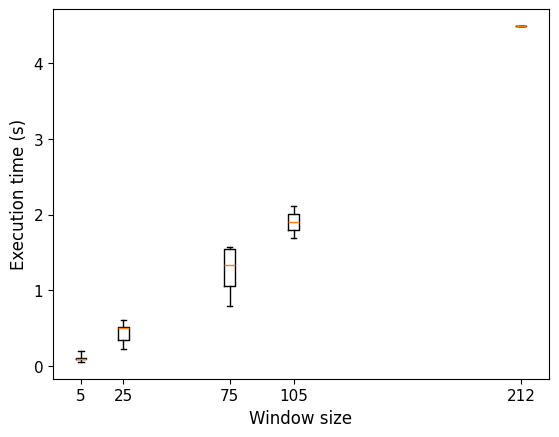

In [49]:
allts = [np.array(t) for (s, t, _, _) in results]
# scores = [np.average(s) for (s, t) in results]
# median = [np.median(s) for (s, t) in results]
# minscore = [np.average(s) - np.std(s) for (s, t) in results]
# maxscore = [np.average(s) + np.std(s) for (s, t) in results]
# times = [t for (s, t) in results]
# plt.plot(ws, scores, 'o-', markersize=2)
# plt.plot(ws, minscore, 'o-', markersize=2)
# plt.plot(ws, maxscore, 'o-', markersize=2)
plt.boxplot(allts, positions=ws, widths=5, showfliers=False, whis=[0, 100])
plt.xlabel("Window size")
plt.ylabel("Execution time (s)")

# plt.plot(ws, median, 'o-', markersize=2)
# plt.xscale('log')

In [50]:
y_test = [getLabelsC(objIndex, 0.5, start, end) for (start, end) in labelRanges for objIndex in range(1,26)]

xtrain_real =  np.array(allTrainingHists)
ytrain_real =  np.array(ytrainboth)
(x,y,z) = np.shape(testx)
xtest_real = np.reshape(testx, ((x*y,z)))
ytest_real = np.array(y_test)


print(np.shape(xtrain_real))
print(np.shape(ytrain_real))
print(np.shape(xtest_real))
print(np.shape(ytest_real))

NameError: name 'testx' is not defined

In [18]:
# Draw the average histogram for each label in the training set
train0 = np.mean(xtrain_real[ytrain_real == 0], axis=0)
train1 = np.mean(xtrain_real[ytrain_real == 1], axis=0)
# Draw the average histogram for each label in the testing set
test0 = np.mean(xtest_real[ytest_real == 0], axis=0)
test1 = np.mean(xtest_real[ytest_real == 1], axis=0)
plt.plot(range(0, len(train0)), train0, label="Train 0 " + str(np.sum(train0)))
plt.plot(range(0, len(train1)), train1, label="Train 1 " + str(np.sum(train1)))
plt.plot(range(0, len(test0)), test0, label="Test 0 " + str(np.sum(test0)))
plt.plot(range(0, len(test1)), test1, label="Test 1 " + str(np.sum(test1)))
plt.legend()
plt.yscale('log')
plt.figure()
print(np.average(ytest_real))
print(np.average(y_test))
print(labelRanges)

NameError: name 'xtest_real' is not defined

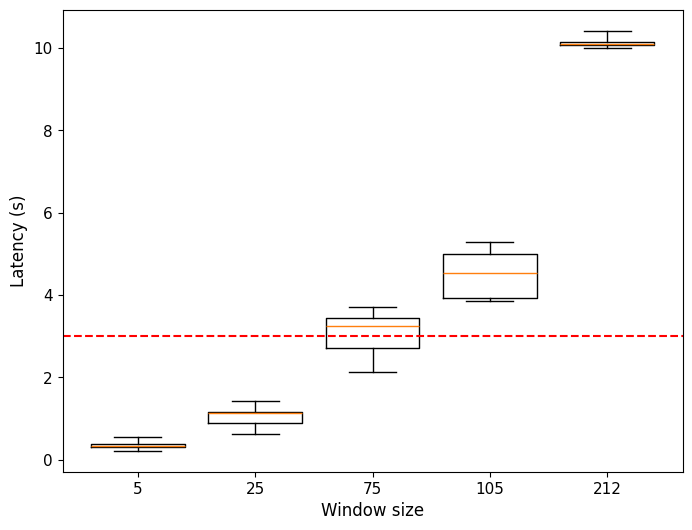

In [51]:
import pickle
with open('just105.pkl', 'rb') as f:
    timing105 = pickle.load(f)
with open('reallysaveddict.pkl', 'rb') as f:
    timings = pickle.load(f)
alltimings = {
    5: timings[5],
    25: timings[25],
    75: timings[75],
    105: timing105[105],
    212: timings[212]
}
import matplotlib.pyplot as plt

allts = alltimings.values()
# allts = [np.array(t) for (s, t, _, _) in results]
# scores = [np.average(s) for (s, t) in results]
# median = [np.median(s) for (s, t) in results]
# minscore = [np.average(s) - np.std(s) for (s, t) in results]
# maxscore = [np.average(s) + np.std(s) for (s, t) in results]
# times = [t for (s, t) in results]
# plt.plot(ws, scores, 'o-', markersize=2)
# plt.plot(ws, minscore, 'o-', markersize=2)
# plt.plot(ws, maxscore, 'o-', markersize=2)
plt.rc('font', size=16)
plt.figure(figsize=(8,6))
plt.boxplot(allts, positions=range(0, len(allts)*10, 10), widths=8, showfliers=False, whis=[0, 100])
plt.xticks(range(0, len(allts)*10, 10), [5,25,75,105,212])
plt.axline((0, 3), (1, 3), color='r', linestyle='--')
plt.xlabel("Window size")
plt.ylabel("Latency (s)")
plt.savefig('timing.pdf', dpi=300, bbox_inches='tight')

# plt.plot(ws, median, 'o-', markersize=2)
# plt.xscale('log')

In [52]:
import numpy as np
for t in timings:
    print (np.min(timings[t]))
for t in timings:
    print (np.max(timings[t]))
for t in timings:
    print (np.average(timings[t]))

0.2216496467590332
0.6349942684173584
2.12699818611145
9.999650955200195
0.5511684417724609
1.437192440032959
3.721473455429077
10.421634435653687
0.34230148803304744
1.0459830963876513
3.0245455203056335
10.111122676531474
